# Neural Style Transfer

<img src="https://www.dropbox.com/s/ocl42wcx9c6y5w1/animate.gif?raw=1" width="900" align = "center"/>
<center>Fig 1. Neural Style Transfer</center>
<br>

According to Wikipedia, Neural Style Transfer (NST) also called Artistic Style Transfer refers to a class of software algorithms that manipulate digital images, or videos, in order to adopt the appearance or visual style of another image. NST algorithms are characterized by their use of deep neural networks for the sake of image transformation.
<br>

***In simple words, Neural style transfer is the process of creating art using computers. It is the process of painting the contents of one image with the style of another.***

## **How does NST work?**
<img src="https://miro.medium.com/max/1294/1*ZgW520SZr1QkGoFd3xqYMw.jpeg" width="700" align = "center"/>
<center>Fig 2. Working</center>
<br>

First, Let's discuss the traditional approach of neural style transfer first given by Gatys et al. in there paper "A Neural Algorithm of Artistic Style".It was built on a very neat idea that, 

    It is possible to separate the style representation and content representations in a CNN, learnt during a computer vision task (e.g. image recognition task).

Neural style transfer uses a pretrained convolution neural network. Then to define a loss function which blends two images seamlessly to create visually appealing art, NST defines the following inputs:

    1. A content image (c) — the image we want to transfer a style to
    2. A style image (s) — the image we want to transfer the style from
    3. An input (generated) image (g) — the image that contains the final result (the only trainable variable)

The basic idea behind this approach is that CNN pretrained on large image datasets develop an intuition of how images and objects in those images look in terms of content and style. The shallow layers of these networks are more concerned with content of the image like shapes and structural details. The deeper layers are good at understanding the texture and style of the image.
<br>

<img src="https://miro.medium.com/max/1400/1*EvBcni8o_O3v4RUl640TZQ@2x.png" width="700" align = "center"/>
<center>Fig 3. Features extracted at different levels</center>
<br>

So, content, style and generated images are passed through the network and the weigts of specific layers are compared using loss fuctions like content loss and style loss. 
<br>

**Content Loss**: The content cost function is making sure that the content present in the content image is captured in the generated image. As CNNs capture information about content in the higher levels, where the lower levels are more focused on individual pixel values, we use the top-most CNN layer to define the content loss function.
<br>

**Style Loss**:To extract the style information from the VGG network, we use all the layers of the CNN. Furthermore, style information is measured as the amount of correlation present between features maps in a given layer. Next, a loss is defined as the difference of correlation present between the feature maps computed by the generated image and the style image.
<br>

Then, an optimizer back-propagates and updates the pixel values of the generated image and the process repeats. This process of searching for pixel values is very slow and not at all practical for styling multiple images.

## The Problem: 
Each new content image will reset the generated image pixels and the process of pixel search needs to be done again. That makes the process very very slow and does not gurantee good results. Due these time and compute constraints, it cannot be implemented in production.


## The Solution: 
The solution is to generalize the approach, using something like a neural net that learns to apply a specific type of style on any input image. Although this approach is also not very good but it is much better than the previous one.

**Advantages**:
* Much faster than the traditional approach
* requires us to train the model only once per style

**Disadvantages**:
* Each style requires its own weights for the model which means it requires a lot of space to save weights for each type of style.

## Fast Neural Style Transfer

<img src="https://www.fritz.ai/images/fast_style_transfer_arch.jpg" width="700" align = "center"/>
<center>Fig 4. Working of TransformerNet and VGG16 for fast NST</center>
<br>

Training a style transfer model requires two networks: a pre-trained feature extractor and a transfer network. The pre-trained feature extractor is used to avoid having to us paired training data. It’s usefulness arises from the curious tendency for individual layers of deep convolutional neural networks trained for image classification to specialize in understanding specific features of an image.
<br>

The pre-trained model enables us to compare the content and style of two images, but it doesn't actually help us create the stylized image. That’s the job of a second neural network, which we’ll call the transfer network. The transfer network is an image translation network that takes one image as input and outputs another image. Transfer networks typically have an encode-decoder architecture.
<br>

At the beginning of training, one or more style images are run through the pre-trained feature extractor, and the outputs at various style layers are saved for later comparison. Content images are then fed into the system. Each content image passes through the pre-trained feature extractor, where outputs at various content layers are saved. The content image then passes through the transfer network, which outputs a stylized image. The stylized image is also run through the feature extractor, and outputs at both the content and style layers are saved.
<br>

The quality of the stylized image is defined by a custom loss function that has terms for both content and style. The extracted content features of the stylized image are compared to the original content image, while the extracted style features are compared to those from the reference style image(s). After each step, only the transfer network is updated. The weights of the pre-trained feature extractor remain fixed throughout. By weighting the different terms of the loss function, we can train models to produce output images with lighter or heavier stylization. 

## Requirements:
For smooth working of this notebook please use these settings. <br>
Create a new virtual environment and install these dependencies in it.
1. Python == 3.7.6
2. Torch == 1.5.1
3. Torchvision == 0.6.0a0+35d732a
4. Numpy == 1.18.1
5. PIL == 5.4.1
6. tqdm == 4.45.0 
7. Matplotlib == 3.2.1
8. OpenCV == 4.2.0.34
9. CUDA Version == 10.1

## Usage:
Run the **fast_trainer** function to train your custom model or use the provided pretrained model with the test function, **test_image**, to generate results.

### Imports and Setup
Let's download all the required files and import all modules.

In [34]:
""" Uncomment and Download data for training (6.1 GB) """
# !wget http://images.cocodataset.org/zips/test2017.zip
# !mkdir './dataset'
# !unzip -q ./test2017.zip -d './dataset'

' Uncomment and Download data for training (6.1 GB) '

In [36]:
""" Download the best model weights """
!mkdir ./checkpoints
!wget -q -O 'best_model.pth' https://www.dropbox.com/s/7xvmmbn1bx94exz/best_model.pth?dl=1
!mv best_model.pth ./checkpoints

mkdir: cannot create directory ‘./checkpoints’: File exists


In [37]:
""" Download content and style images """
!mkdir ./content
!mkdir ./style
!wget -q https://github.com/myelinfoundry-2019/challenge/raw/master/japanese_garden.jpg -P './content'
!wget -q https://github.com/myelinfoundry-2019/challenge/raw/master/picasso_selfportrait.jpg -P './style'

mkdir: cannot create directory ‘./content’: File exists
mkdir: cannot create directory ‘./style’: File exists


In [38]:
import torch
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) #for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mean and standard deviation used for training
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

## Defining Models
Here we have 2 models
1. **VGG16**: Pre-trained model for feature extraction for loss comparisions.
2. **TransformerNet**: The main model which acts as an encoder-decoder pair and learns to convert any image to a specific style.

In [39]:
""" Pretrained VGG16 Model """
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        
        
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out


""" Transformer Net """
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)


""" Components of Transformer Net """
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

## Utility functions
These functions help in the training process from preprocessing the input image to calculating the gram-matrix for loss calculation.

In [40]:
def gram_matrix(y):
    """ Returns the gram matrix of y (used to compute style loss) """
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram


def train_transform(image_size):
    """ Transforms for training images """
    transform = transforms.Compose(
        [
            transforms.Resize((int(image_size * 1.15),int(image_size * 1.15))),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform


def style_transform(image_size=None):
    """ Transforms for style image """
    resize = [transforms.Resize((image_size,image_size))] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def test_transform(image_size=None):
    """ Transforms for test image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors


def deprocess(image_tensor):
    """ Denormalizes and rescales image tensor """
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np

## Training Loop
This is our main training loop. Here we follow a specific order of steps to train our neural net. The steps are as follows:
1. First, the train dataloaders are initialized to provide us with the batches of data that the model will use to train on.
2. Then the neural nets are initialized for usage.
3. After that we initialize optimizer which will update the weights of the model and help in training. The optimizer takes a very important hyperparameter called **learning rate** which defines how intensly model weights are updated. A good learning rate marks the balance between slow training and overshooting.
4. Next, we transform our input images to desired shape and keep a small set of 8 images aside for validation purpose. These 8 images are used to understand how the model training progresses.
5. After this, the main process starts. The outer loop runs "epochs" number of times. The inner loop iterates over the batches provided by the dataloader. Model output is generated for the input image, loss is calculated for the whole batch and model weights are updated using back-propogation. All this runs multiple times in each epoch.
6. During the training we keep saving the model weights and ouput of the model on the validation set we kept aside earlier.

Please find all my experiments and there outputs [here.](https://drive.google.com/drive/folders/13jTfhQVB2qojOD3cb9EF7-Uy_afYUbDE?usp=sharing)

In [45]:
def fast_trainer(style_image,    
                 style_name,     
                 dataset_path,   
                 image_size=256,
                 style_size=448,
                 batch_size = 8,
                 lr = 1e-5,
                 epochs = 1,
                 checkpoint_model = None,
                 checkpoint_interval=200,
                 sample_interval=200,
                 lambda_style=10e10,
                 lambda_content=10e5,):
    
    os.makedirs(f"./images/outputs/{style_name}-training", exist_ok=True)
    os.makedirs(f"./checkpoints", exist_ok=True)


    """ Create dataloader for the training data """
    train_dataset = datasets.ImageFolder(dataset_path, train_transform(image_size))
    dataloader = DataLoader(train_dataset, batch_size=batch_size)

    """ Define networks """
    transformer = TransformerNet().to(device)
    vgg = VGG16(requires_grad=False).to(device)

    """ Load checkpoint model if specified """
    if checkpoint_model:
        transformer.load_state_dict(torch.load(checkpoint_model))

    """ Define optimizer and loss """
    optimizer = Adam(transformer.parameters(), lr)
    l2_loss = torch.nn.MSELoss().to(device)

    """ Load style image """
    style = style_transform(style_size)(Image.open(style_image))
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    """ Extract style features """
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]

    """ Sample 8 images for visual evaluation of the model """
    image_samples = []
    for path in random.sample(glob.glob(f"{dataset_path}/*/*.jpg"), 8):
        image_samples += [style_transform(image_size)(Image.open(path))]
    image_samples = torch.stack(image_samples)

    def save_sample(batches_done):
        """ Evaluates the model and saves image samples """
        transformer.eval()
        with torch.no_grad():
            output = transformer(image_samples.to(device))
        image_grid = denormalize(torch.cat((image_samples.cpu(), output.cpu()), 2))
        save_image(image_grid, f"./images/outputs/{style_name}-training/{batches_done}.jpg", nrow=4)
        transformer.train()
    
    
    train_metrics = {"content": [], "style": [], "total": []}
    for epoch in range(epochs):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # Extract features
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # Compute content loss as MSE between features
            content_loss = lambda_content * l2_loss(features_transformed.relu2_2, features_original.relu2_2)

            # Compute style loss as MSE between gram matrices
            style_loss = 0
            for ft_y, gm_s in zip(features_transformed, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += l2_loss(gm_y, gm_s[: images.size(0), :, :])
            style_loss *= lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]
            
            train_metrics["content"] += [content_loss.item()]
            train_metrics["style"] += [style_loss.item()]
            train_metrics["total"] += [total_loss.item()]

            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    epoch + 1,
                    epochs,
                    batch_i,
                    len(train_dataset),
                    content_loss.item(),
                    np.mean(epoch_metrics["content"]),
                    style_loss.item(),
                    np.mean(epoch_metrics["style"]),
                    total_loss.item(),
                    np.mean(epoch_metrics["total"]),
                )
            )

            batches_done = epoch * len(dataloader) + batch_i + 1
            if batches_done % sample_interval == 0:
                save_sample(batches_done)

            if checkpoint_interval > 0 and batches_done % checkpoint_interval == 0:
                torch.save(transformer.state_dict(), f"./checkpoints/{style_name}_{batches_done}.pth")


            torch.save(transformer.state_dict(), f"./checkpoints/last_checkpoint.pth")
    
    print("Training Completed!")
    plt.plot(train_metrics["content"], label = "Content Loss")
    plt.plot(train_metrics["style"], label = "Style Loss")
    plt.plot(train_metrics["total"], label = "Total Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

## Testing and Inference Loop
After the model has been trained it can be used to generate outputs for desired inputs. Each model is trained on a single style and can produce images with that single style. That means we require multiple model, one model per style, if we want to use this in production. 

In [46]:
def test_image(image_path,checkpoint_model,save_path):
    os.makedirs(os.path.join(save_path,"results"), exist_ok=True)

    transform = test_transform()

    # Define model and load model checkpoint
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(checkpoint_model))
    transformer.eval()

    # Prepare input
    image_tensor = Variable(transform(Image.open(image_path))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    # Stylize image
    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()
    # Save image
    fn = checkpoint_model.split('/')[-1].split('.')[0]
    save_image(stylized_image, os.path.join(save_path,f"results/{fn}-output.jpg"))
    print("Image Saved!")
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(save_path,f"results/{fn}-output.jpg")), cv2.COLOR_BGR2RGB))

### To train run this:

[Epoch 1/1] [Batch 624/5000] [Content: 6675472.00 (7361326.02) Style: 3834774.50 (10126731.21) Total: 10510246.00 (17488057.22)]]

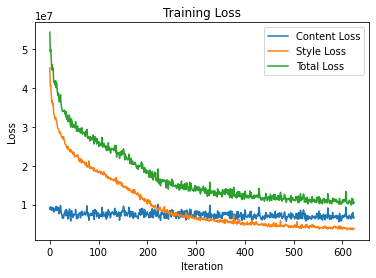

In [47]:
""" Uncomment and run to train the model """
fast_trainer(style_image='./style/picasso_selfportrait.jpg',style_name = 'Picasso_Selfportrait',
             dataset_path='./dataset', epochs = 4)

### To test on your own image run this:

Image Saved!


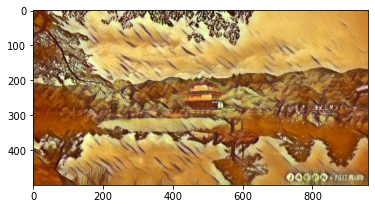

In [49]:
test_image(image_path = './content/japanese_garden.jpg',
           checkpoint_model = './checkpoints/best_model.pth',
           save_path = './')

## Experiments
I experimented with different layer formats and style and content weights and these are the results of each experiment.

<img src="https://www.dropbox.com/s/ikaq1w8ywmurbk1/Screenshot_2020-07-04%20yash-choudhary%20Neural-Style-Transfer.png?raw=1" width="500" align = "center"/>
<center>Table 1. Experiments</center>
<br>
<br>
Now let's look the results of each experiment at different instances.
<br>
<br>
<img src="https://www.dropbox.com/s/7plcfdag664z5k5/grid.png?raw=1" width="900" align = "center"/>
<center>Fig 5. Best Result 1 [More Weight to Style]</center>

## Result
The 3 best outputs from my models are:

<img src="https://www.dropbox.com/s/8a7i1qufrn2th8i/best_output1.jpg?raw=1" width="500" align = "center"/>
<center>Fig 6. Best Result 1 [More Weight to Style]</center>
<br>
<img src="https://www.dropbox.com/s/mmyikx154whtufj/best_output2.jpg?raw=1" width="500" align = "center"/> 
<center>Fig 7. Best Result 2 [Balanced Style and content]</center>
<br>
<img src="https://www.dropbox.com/s/h7nrahjbek3ajq1/best_output3.jpg?raw=1" width="500" align = "center"/>
<center>Fig 8. Best Result 3 [More Weight to Content]</center>

Please find detailed experiment results [here.](https://drive.google.com/drive/folders/13jTfhQVB2qojOD3cb9EF7-Uy_afYUbDE?usp=sharing)

### Important Links
1. Train Dataset Link: http://images.cocodataset.org/zips/test2017.zip <br>
2. Style Image: https://github.com/myelinfoundry-2019/challenge/raw/master/picasso_selfportrait.jpg <br>
3. Content Image: https://github.com/myelinfoundry-2019/challenge/raw/master/japanese_garden.jpg <br>
4. Best Model: https://www.dropbox.com/s/7xvmmbn1bx94exz/best_model.pth?dl=1
<br>
<br>

### References:
1. [Style Transfer Guide](https://www.fritz.ai/style-transfer/)
2. [Breaking Down Leon Gatys’ Neural Style Transfer in PyTorch](https://towardsdatascience.com/breaking-down-leon-gatys-neural-style-transfer-in-pytorch-faf9f0eb79db)
3. [Intuitive Guide to Neural Style Transfer](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee)
4. [A Neural Algorithm of Artistic Style By
Leon A. Gatys, Alexander S. Ecker, Matthias Bethge](https://arxiv.org/abs/1508.06576)
5. [Perceptual Losses for Real-Time Style Transfer and Super-Resolution by Justin Johnson, Alexandre Alahi, Li Fei-Fei](https://arxiv.org/abs/1603.08155)
6. [Neural Style Transfer on Real Time Video (With Full implementable code)](https://towardsdatascience.com/neural-style-transfer-on-real-time-video-with-full-implementable-code-ac2dbc0e9822)
7. [Classic Neural Style Transfer](https://github.com/halahup/NeuralStyleTransfer)
8. [Fast Neural Style Transfer using Lua](https://github.com/lengstrom/fast-style-transfer)
9. [Fast Neural Style Transfer using Python](https://github.com/eriklindernoren/Fast-Neural-Style-Transfer)